In [ ]:
      
# https://www.kdnuggets.com/2020/07/pytorch-lstm-text-generation-tutorial.html

In [ ]:
import torchtext
from torchtext.data.utils import get_tokenizer
from sklearn.model_selection import train_test_split
import re
!pip install cleantext
from cleantext import clean
import os
import random
import math
from nltk.tokenize import TweetTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Preprocess the data 

tweet_tokenizer = TweetTokenizer()
tokenizer = get_tokenizer('basic_english')

def replace_dates(text):
        date_format_a = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', ' <DATE> ', text)
        date_format_b = re.sub(
            r'[A-Za-z]{2,8}\s\d{1,2},?\s\d {4}', ' <DATE> ', date_format_a)
        date_format_c = re.sub(
            r'\d{2} [A-Z][a-z]{2,8} \d{4}', ' <DATE> ', date_format_b)
        return date_format_c

def replace_concurrent_punctuation(text):
    # replace concurrent punctuation with single punctuation
    return re.sub(r'(!|"|\#|\$|%|&|\'|\(|\)|\*|\+|,|-|\.|\/|:|;|<|=|>|\?|@|\[|\\|\]|\^|_|‘|\{|\||\}|~){2,}', r' ', text)

def replace_hash_tags(text):
        return re.sub(r'(\s|^)#(\w+)', ' <HASHTAG> ', text)

def remove_special_characters(text):
        # remove special characters other than punctuation
        return re.sub(r'[^A-Za-z0-9\s\.\,\!\?\'\"\:\;]', ' ', text)

def remove_extra_spaces(text):
        return re.sub(r'\s{2,}', ' ', text)

def replace_hyphenated_words(text):
        # replace hyphenated words with words seperated by space
        return re.sub(r'(\w+)-(\w+)', r'\1 \2', text)

def read_data(filename, n_lines):
    with open(filename, 'r') as f:
        lines = []
        for _ in range(n_lines):
            line = f.readline().strip()
            line = re.sub(r'<|>', ' ', line)
            line = replace_dates(line)
            line = replace_hyphenated_words(line)
            line = replace_hash_tags(line)
            # remove < and > from the text
            line = clean(line, no_emoji=True,
                         no_urls=True,
                         no_emails=True,
                         no_phone_numbers=True,
                         no_currency_symbols=True,           
                         replace_with_url=" <URL> ",
                         replace_with_email=" <EMAIL> ",
                         replace_with_phone_number=" <PHONE> ",
                         replace_with_currency_symbol=" <CURRENCY> ",
                         lower=True)
            line = remove_special_characters(line)
            #line = replace_concurrent_punctuation(line)
            line = clean(line,no_numbers=True,no_digits=True,no_punct=True, replace_with_number=" <NUMBER> ",replace_with_digit=" ",replace_with_punct="")
            line = "<BEGIN> " + line + " <END>"
            line = remove_extra_spaces(line)
            tokens=tokenizer(line)
            if len(tokens)>1:
                lines.append(tokens)
    return lines


def save_data(filename, lines):
    # Save the data to a file
    with open(filename, 'w')as f:
        for line in lines:
            line = ' '.join(line)
            f.write(line.strip()+'\n')




In [ ]:
# if not os.path.exists('./processed_data'):
#     os.mkdir('processed_data')

# data = read_data('data/alternate/L3Cube-HingCorpus_roman/R11_final_data/concatenated_train_final_shuffled.txt',20000)
# train,valid = train_test_split(data, test_size=0.3, random_state=42)
# valid,test=train_test_split(valid, test_size=0.5, random_state=42)
# #print(train[1:100])
# save_data('processed_data/train.txt', train)
# save_data('processed_data/valid.txt', valid)
# save_data('processed_data/test.txt', test)

In [ ]:
#---------------------------------------------------------------------

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [ ]:
class L3CubeDataset(Dataset):
    def __init__(self,filename,vocab=None,ngram=5):
        data = self.read_data(filename)
        if vocab is None:
            self.vocab, self.ind2vocab = self.build_vocab(data)
        else:
            self.vocab = vocab
            self.ind2vocab = {v:k for k,v in vocab.items()}
        self.n = ngram
        self.x,self.y = self.__create_dataset(data)
        
    def get_vocab(self):
        return self.vocab

    def read_data(self,filename):
        lines = []
        with open(filename, 'r') as f:
            for line in f.readlines():
                lines.append(line.strip().split(' '))
        return lines

    def build_vocab(self,data):
        word_set = set()
        for line in data:
            for word in line:
                if word not in word_set:
                    word_set.add(word)
        # sort the vocab
        word_list = sorted(list(word_set))
        vocab_dict = {"<unk>":0}
        for i,word in enumerate(word_list):
            vocab_dict[word]=i+1
        ind2word = {v:k for k,v in vocab_dict.items()}
        return vocab_dict, ind2word
    
    def get_ngram(self, tokens):
        n =self.n
        ngram = []
        if len(tokens) == 0:
            return None
        tokens = ["<begin>" for _ in range(n-2)] + tokens
        for i in range(len(tokens)-n+1):
            ngram.append(tokens[i:i+n])
        return ngram
    
    def __get_seq(self, tokens):
        vec= []
        for word in tokens:
            if word in self.vocab:
                vec.append(self.vocab[word])
            else:
                vec.append(self.vocab["<unk>"])
        return vec

    def __create_dataset(self, data):
        x = []
        y= []
        ngrams = []
        for line in data:
            ngrams.extend(self.get_ngram(line))
        
        for ngram in ngrams:
            x_tokens = ngram[:-1]
            y_tokens = ngram[1:]
            x.append(self.__get_seq(x_tokens))
            y.append(self.__get_seq(y_tokens))
        return torch.LongTensor(x),torch.LongTensor(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def get_dataloader(self, batch_size,shuffle=True):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle,drop_last=True)
    

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader


class LinceDataset(Dataset):
    def __init__(self, filename, vocab_english=None, vocab_hinglish=None, ngram=5):
        data_english, data_hinglish = self.read_data(filename)
        self.word_count ={}
        self.single_counts = 0
        for list_tokens in data_hinglish:
            for token in list_tokens:
                if token not in self.word_count:
                    self.word_count[token] = 0
                self.word_count[token] += 1
        
        for word in self.word_count:
            if self.word_count[word] == 1: 
                self.single_counts += 1

        if vocab_hinglish is None:
            self.vocab_h, self.ind2vocab_h = self.build_vocab(data_hinglish)
        else:
            self.vocab_h = vocab_hinglish
            self.ind2vocab_h = {v: k for k, v in vocab_hinglish.items()}
        self.n = ngram
        self.x, self.y = self.__create_dataset(data_hinglish)

    def get_vocab(self):
        return self.vocab_h

    def read_data(self, filename):
        english = []
        hinglish = []
        with open(filename, 'r') as f:
            for line in f.readlines():
                e = line.strip().split('\t')[0]
                english.append(e.strip().split(' '))
                try:
                    h = line.strip().split('\t')[1]
                except:
                    h = ""
                hinglish.append(h.strip().split(' '))
        return english, hinglish

    def build_vocab(self, data):
        word_set = set()
        for line in data:
            for word in line:
                if word not in word_set:
                    word_set.add(word)
        # sort the vocab
        word_list = sorted(list(word_set))
        vocab_dict = {"<unk>": 0}
        for i, word in enumerate(word_list):
            vocab_dict[word] = i+1
        ind2word = {v: k for k, v in vocab_dict.items()}
        return vocab_dict, ind2word

    def get_ngram(self, tokens):
        n = self.n
        ngram = []
        if len(tokens) == 0:
            return None
        tokens = ["<begin>" for _ in range(n-2)] + tokens
        for i in range(len(tokens)-n+1):
            ngram.append(tokens[i:i+n])
        return ngram

    def __get_seq(self, tokens):
        vec = []
        for word in tokens:
            if word in self.vocab_h:
                vec.append(self.vocab_h[word])
            else:
                vec.append(self.vocab_h["<unk>"])
        return vec

    def __create_dataset(self, data):
        x = []
        y = []
        ngrams = []
        for line in data:
            ngrams.extend(self.get_ngram(line))

        for ngram in ngrams:
            x_tokens = ngram[:-1]
            y_tokens = ngram[1:]
            x.append(self.__get_seq(x_tokens))
            y.append(self.__get_seq(y_tokens))
        return torch.LongTensor(x), torch.LongTensor(y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def get_dataloader(self, batch_size, shuffle=True):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, drop_last=True)

In [ ]:
train_dataset = LinceDataset('drive/MyDrive/model_nlp_project/data/lince/train.txt')
test_dataset = LinceDataset('drive/MyDrive/model_nlp_project/data/lince/test.txt',vocab_hinglish=train_dataset.get_vocab())
validation_dataset = LinceDataset('drive/MyDrive/model_nlp_project/data/lince/valid.txt',vocab_hinglish=train_dataset.get_vocab())

In [ ]:
# train_dataset = L3CubeDataset('processed_data/train.txt')
# validation_dataset = L3CubeDataset('processed_data/valid.txt',vocab=train_dataset.get_vocab())

In [ ]:
import json
json.dump(train_dataset.get_vocab(),open('vocab.json','w'))
len(train_dataset.get_vocab())

9237

In [ ]:
vocab_dict = train_dataset.get_vocab()
i=0
for word in vocab_dict:
    if i == 10:
        break
    if len(word) > 10:
        print(word)
        i+=1



aakhirakaar
aalochanaatmak
aanandadaayak
aashcharyachakit
aashcharyajanak
aatmavishvaas
aavashyakata
acceidentally
accidentally
accomplished


In [ ]:
print(train_dataset.x[2],train_dataset.y[2])

tensor([   1,    1,  947, 8904]) tensor([   1,  947, 8904, 8052])


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
import numpy as np
import os

In [ ]:
class GramNet(nn.Module):
    def __init__(self,vocab_size, n_hidden=256, n_layers=4,embedding_dim=200, dropout=None, lr=0.001,model_save_path='.',device='cuda'):
        super().__init__()
        self.dropout = dropout
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        self.model_save_path = model_save_path
        self.device = device
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if dropout is not None:
            self.rnn = nn.LSTM(embedding_dim, n_hidden, n_layers, dropout=dropout,batch_first=True)
        else:
            self.rnn = nn.LSTM(embedding_dim, n_hidden, n_layers,batch_first=True)
            dropout = 0
        self.fc = nn.Linear(n_hidden, vocab_size)
        self.model_name = 'GramNet_'+str(n_hidden)+'_'+str(n_layers)+'_'+str(dropout)+'_'+str(lr)+'.pt'
    
    def forward(self, x, hidden):
        embedded = self.embedding(x)     
        out, hidden = self.rnn(embedded, hidden)
#         out = self.dropout(out)
        out = out.reshape(-1, self.n_hidden) 
        out = self.fc(out)
        return out, hidden
    
    def __init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return hidden
    
    def get_hidden(self,b):
        return self.__init_hidden(b)

    def accuracy(self,true, pred):
        true = np.array(true)
        pred = np.array(pred)
        num_correct = sum(true == pred)
        num_total = len(true)
        return num_correct / num_total


    def run_training(self,train_dataset,valid_dataset, epochs=10, batch_size=32, clip = 1,print_every=1):
        device = self.device
        if str(device) == 'cpu':
            print("Training only supported in GPU environment")
            return
        torch.cuda.empty_cache()
        self.to(device)
        train_loader = train_dataset.get_dataloader(batch_size)
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        self.train()
        for epoch in range(epochs):
            hidden = self.__init_hidden(batch_size)
            for i, (x, y) in enumerate(train_loader):
                hidden = tuple([each.data for each in hidden])
                x, y = x.to(device), y.to(device)
                #print(x)
                output, hidden = self.forward(x, hidden)
                #hidden.detach_()
                loss = criterion(output, y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                clip_grad_norm_(self.parameters(), clip)
                optimizer.step()
            if i % print_every == 0:
                acc,_ = self.evaluate(train_dataset)
                acc2,_ = self.evaluate(valid_dataset)
                self.train()
                print("Epoch: {}/{}".format(epoch+1, epochs),
#                       "Step: {}".format(i),
                      "Loss: {}".format(loss.item()),
                      "Training Accuracy: {}".format(acc),
                      "Validation Accuracy: {}".format(acc2))
        self.save(os.path.join(self.model_save_path,self.model_name))
                    
    def evaluate(self, dataset,batch_size=32):
        device = self.device
        self.to(device)
        self.eval()
        loader = dataset.get_dataloader(batch_size)
        hidden = self.__init_hidden(batch_size)
        preds = []
        trues = []
        total_loss = 0
        num_tokens = 0
        perp = []
        for i, (x, y) in enumerate(loader):
            hidden = tuple([each.data for each in hidden])
            x, y = x.to(device), y.to(device)
            criterion = nn.CrossEntropyLoss()
            output, hidden = self.forward(x, hidden)
            loss = criterion(output, y.view(-1))
            preds.extend(output.argmax(dim=1).cpu().numpy())
            trues.extend(y.view(-1).cpu().numpy())
            total_loss += loss.item()* batch_size
            num_tokens += batch_size * 5
            perp.append(2 ** loss.item())
        perplexity = 2 ** math.exp(total_loss / num_tokens)
        accuracy = self.accuracy(trues, preds)
        return accuracy, preds, perplexity

    def predict(self,inputs):
        self.eval()
        device = self.device
        inputs = torch.LongTensor(inputs)
        #inputs = inputs.to(device)
        hidden = self.__init_hidden(1)
        output, hidden = self.forward(inputs, hidden)
        #return output.argmax(dim=1).cpu().numpy()

    def save(self,filename):
        torch.save(self.state_dict(), filename)

    def load(self,filename):
        self.load_state_dict(torch.load(filename))

In [ ]:
vocab_size =len(train_dataset.get_vocab())
net = GramNet(vocab_size,512,3,200,0.2,0.001,"saved_models")
print(net)

GramNet(
  (embedding): Embedding(9237, 200)
  (rnn): LSTM(200, 512, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=9237, bias=True)
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

In [ ]:
net.load('./drive/MyDrive/model_nlp_project/v1.pt')

In [ ]:
# #net.run_training(train_dataset,validation_dataset, epochs=80, batch_size=64, clip = 1,print_every=1)
train_stats = """Epoch: 1/80 Loss: 4.5537919998168945 Training Accuracy: 0.22085860688233427 Validation Accuracy: 0.19896640826873385
Epoch: 2/80 Loss: 4.471576690673828 Training Accuracy: 0.26114018395179195 Validation Accuracy: 0.215984334625323
Epoch: 3/80 Loss: 3.970032215118408 Training Accuracy: 0.3101783024104028 Validation Accuracy: 0.21961805555555555
Epoch: 4/80 Loss: 3.6524453163146973 Training Accuracy: 0.3547737274024738 Validation Accuracy: 0.22040536175710596
Epoch: 5/80 Loss: 3.5003488063812256 Training Accuracy: 0.3924461822074215 Validation Accuracy: 0.21759932170542637
Epoch: 6/80 Loss: 3.3980283737182617 Training Accuracy: 0.4235153028861402 Validation Accuracy: 0.2194969315245478
Epoch: 7/80 Loss: 3.014065980911255 Training Accuracy: 0.44787206628607673 Validation Accuracy: 0.21537871447028423
Epoch: 8/80 Loss: 2.737579584121704 Training Accuracy: 0.4696543966064066 Validation Accuracy: 0.21535852713178294
Epoch: 9/80 Loss: 2.865597724914551 Training Accuracy: 0.4891298961306692 Validation Accuracy: 0.21335998062015504
Epoch: 10/80 Loss: 2.801888942718506 Training Accuracy: 0.5038356327307326 Validation Accuracy: 0.21406653746770027
Epoch: 11/80 Loss: 2.871608018875122 Training Accuracy: 0.5169778782112274 Validation Accuracy: 0.21188630490956073
Epoch: 12/80 Loss: 2.5750842094421387 Training Accuracy: 0.5275878131937837 Validation Accuracy: 0.21331960594315247
Epoch: 13/80 Loss: 2.703486442565918 Training Accuracy: 0.5353061568347606 Validation Accuracy: 0.21004925710594316
Epoch: 14/80 Loss: 2.473367214202881 Training Accuracy: 0.5444839240405963 Validation Accuracy: 0.21136143410852712
Epoch: 15/80 Loss: 2.394268274307251 Training Accuracy: 0.5509410680304472 Validation Accuracy: 0.21029150516795866
Epoch: 16/80 Loss: 2.518132209777832 Training Accuracy: 0.5580523509356169 Validation Accuracy: 0.21047319121447028
Epoch: 17/80 Loss: 2.558898448944092 Training Accuracy: 0.563188828100222 Validation Accuracy: 0.21023094315245477
Epoch: 18/80 Loss: 2.4203193187713623 Training Accuracy: 0.5684739732001268 Validation Accuracy: 0.2082122093023256
Epoch: 19/80 Loss: 2.3452253341674805 Training Accuracy: 0.5729587892483349 Validation Accuracy: 0.2096858850129199
Epoch: 20/80 Loss: 2.546687602996826 Training Accuracy: 0.5763137289882652 Validation Accuracy: 0.20774790051679587
Epoch: 21/80 Loss: 2.4848430156707764 Training Accuracy: 0.5803550190294957 Validation Accuracy: 0.21004925710594316
Epoch: 22/80 Loss: 2.2809205055236816 Training Accuracy: 0.5825825602600698 Validation Accuracy: 0.20948401162790697
Epoch: 23/80 Loss: 2.3257436752319336 Training Accuracy: 0.5857739652711703 Validation Accuracy: 0.20792958656330748
Epoch: 24/80 Loss: 2.3423948287963867 Training Accuracy: 0.5875654138915318 Validation Accuracy: 0.20960513565891473
Epoch: 25/80 Loss: 2.339360237121582 Training Accuracy: 0.5900531240088804 Validation Accuracy: 0.20986757105943152
Epoch: 26/80 Loss: 2.198197841644287 Training Accuracy: 0.5919387289882652 Validation Accuracy: 0.20754602713178294
Epoch: 27/80 Loss: 2.141395092010498 Training Accuracy: 0.5940845028544244 Validation Accuracy: 0.2099483204134367
Epoch: 28/80 Loss: 2.3439297676086426 Training Accuracy: 0.5959155962575325 Validation Accuracy: 0.20867651808785528
Epoch: 29/80 Loss: 2.173868179321289 Training Accuracy: 0.5974840429749445 Validation Accuracy: 0.20859576873385013
Epoch: 30/80 Loss: 2.2253670692443848 Training Accuracy: 0.5979374801776086 Validation Accuracy: 0.20619347545219638
Epoch: 31/80 Loss: 2.3426148891448975 Training Accuracy: 0.6009058832857596 Validation Accuracy: 0.2093830749354005
Epoch: 32/80 Loss: 2.332681894302368 Training Accuracy: 0.6019267364414843 Validation Accuracy: 0.20897932816537468
Epoch: 33/80 Loss: 2.2014544010162354 Training Accuracy: 0.6040130431335237 Validation Accuracy: 0.2081314599483204
Epoch: 34/80 Loss: 2.274782419204712 Training Accuracy: 0.6047687718046305 Validation Accuracy: 0.20778827519379844
Epoch: 35/80 Loss: 2.1733882427215576 Training Accuracy: 0.6062430621630194 Validation Accuracy: 0.20843427002583978
Epoch: 36/80 Loss: 2.387843370437622 Training Accuracy: 0.6064462416745956 Validation Accuracy: 0.20784883720930233
Epoch: 37/80 Loss: 2.2462077140808105 Training Accuracy: 0.6079254876308278 Validation Accuracy: 0.2066779715762274
Epoch: 38/80 Loss: 2.376753091812134 Training Accuracy: 0.6089537741833174 Validation Accuracy: 0.20696059431524547
Epoch: 39/80 Loss: 2.3456149101257324 Training Accuracy: 0.6089859855692991 Validation Accuracy: 0.20726340439276486
Epoch: 40/80 Loss: 2.1606013774871826 Training Accuracy: 0.6090578417380272 Validation Accuracy: 0.20496204780361757
Epoch: 41/80 Loss: 2.271935224533081 Training Accuracy: 0.6103685973675864 Validation Accuracy: 0.20803052325581395
Epoch: 42/80 Loss: 2.3323261737823486 Training Accuracy: 0.6111144148430067 Validation Accuracy: 0.20552729328165376
Epoch: 43/80 Loss: 2.3810842037200928 Training Accuracy: 0.6130272756105296 Validation Accuracy: 0.2079497739018088
Epoch: 44/80 Loss: 2.234307050704956 Training Accuracy: 0.6117561647637171 Validation Accuracy: 0.20744509043927647
Epoch: 45/80 Loss: 2.23294734954834 Training Accuracy: 0.6126010941960038 Validation Accuracy: 0.20623385012919895
Epoch: 46/80 Loss: 2.2656517028808594 Training Accuracy: 0.6141298961306692 Validation Accuracy: 0.20673853359173128
Epoch: 47/80 Loss: 2.1471002101898193 Training Accuracy: 0.615076415318744 Validation Accuracy: 0.20831314599483206
Epoch: 48/80 Loss: 2.2624404430389404 Training Accuracy: 0.6146180225182366 Validation Accuracy: 0.20744509043927647
Epoch: 49/80 Loss: 2.067301034927368 Training Accuracy: 0.6156537424674913 Validation Accuracy: 0.20439680232558138
Epoch: 50/80 Loss: 2.1581404209136963 Training Accuracy: 0.6166250396447828 Validation Accuracy: 0.20772771317829458
Epoch: 51/80 Loss: 2.3004283905029297 Training Accuracy: 0.6159337337456391 Validation Accuracy: 0.20568879198966408
Epoch: 52/80 Loss: 2.162137031555176 Training Accuracy: 0.6173659015223597 Validation Accuracy: 0.20548691860465115
Epoch: 53/80 Loss: 2.293323516845703 Training Accuracy: 0.6176062480177609 Validation Accuracy: 0.2058704780361757
Epoch: 54/80 Loss: 2.1614606380462646 Training Accuracy: 0.6171032548366635 Validation Accuracy: 0.20708171834625322
Epoch: 55/80 Loss: 2.266111373901367 Training Accuracy: 0.6180547296225817 Validation Accuracy: 0.20776808785529716
Epoch: 56/80 Loss: 2.1275548934936523 Training Accuracy: 0.6175988146209959 Validation Accuracy: 0.20623385012919895
Epoch: 57/80 Loss: 2.2212812900543213 Training Accuracy: 0.6184387884554393 Validation Accuracy: 0.20597141472868216
Epoch: 58/80 Loss: 2.180265426635742 Training Accuracy: 0.6187931137012369 Validation Accuracy: 0.20504279715762275
Epoch: 59/80 Loss: 2.205768346786499 Training Accuracy: 0.6188352362829052 Validation Accuracy: 0.20837370801033592
Epoch: 60/80 Loss: 2.117110013961792 Training Accuracy: 0.619246550903901 Validation Accuracy: 0.20653666020671835
Epoch: 61/80 Loss: 2.223167657852173 Training Accuracy: 0.6185379004123057 Validation Accuracy: 0.20724321705426357
Epoch: 62/80 Loss: 2.2225825786590576 Training Accuracy: 0.6198337892483349 Validation Accuracy: 0.20578972868217055
Epoch: 63/80 Loss: 2.0167605876922607 Training Accuracy: 0.6199775015857913 Validation Accuracy: 0.20807089793281655
Epoch: 64/80 Loss: 2.2954180240631104 Training Accuracy: 0.6193159292737076 Validation Accuracy: 0.20637516149870802"""

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
data = {
    'Epoch': [i for i in range(1,65)]
}
data['Loss']= [float(i.split()[3]) for i in train_stats.split('\n')]
df = pd.DataFrame(data,columns=['Epoch','Loss'])
print(df[:20])

    Epoch      Loss
0       1  4.553792
1       2  4.471577
2       3  3.970032
3       4  3.652445
4       5  3.500349
5       6  3.398028
6       7  3.014066
7       8  2.737580
8       9  2.865598
9      10  2.801889
10     11  2.871608
11     12  2.575084
12     13  2.703486
13     14  2.473367
14     15  2.394268
15     16  2.518132
16     17  2.558898
17     18  2.420319
18     19  2.345225
19     20  2.546688


<Axes: xlabel='Epoch'>

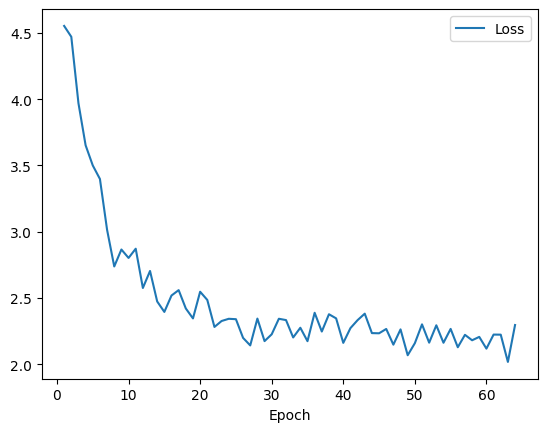

In [ ]:
df.plot(x ='Epoch', y='Loss', kind = 'line')

In [ ]:
val_acc, val_pred, val_per = net.evaluate(validation_dataset)

In [ ]:
train_acc, train_pred, train_per = net.evaluate(train_dataset)

In [ ]:
train_per

2.682654359226992

In [ ]:
val_per

215.4213812875917

In [ ]:
def predict(net, dataset,device, word, hidden_state):
    token2int = dataset.get_vocab()
    int2token = dataset.ind2vocab_h
    inputs = torch.tensor(token2int[word]).unsqueeze(0).unsqueeze(0).cuda()
    hidden_state = tuple([each.data for each in hidden_state])
    out, hidden_state = net(inputs, hidden_state)
    output = torch.softmax(out, dim=1).squeeze().cpu().detach().numpy()
    top_n_idx = output.argsort()[::-1][:3]

    sampled_token_index = token2int['<unk>']
    while int2token[sampled_token_index]=='<unk>':
      sampled_token_index = np.random.choice(top_n_idx)

    return int2token[sampled_token_index], hidden_state

def generate(net, dataset,device, size, seed='it is'):
    net.cuda()
    net.eval()
    hidden_state = net.get_hidden(1)
    all_tokens = seed.split()
    for word in seed.split():
        token, hidden_state = predict(net,dataset,device, word, hidden_state)
    all_tokens.append(token)
    for i in range(size-1):
        token, hidden_state = predict(net, dataset,device, all_tokens[-1], hidden_state)
        all_tokens.append(token)
    return ' '.join(all_tokens)

In [ ]:
generate(net,train_dataset,device,7,"life me always")

'life me always wonder woman ke sneak peek hoge tho'

In [ ]:
!apt install enchant
!pip install PyEnchant
import enchant

In [ ]:
def get_mix_factor(sentences):
    encs = enchant.Dict("en_IN")
    mix_factor = []
    for sentence in sentences:
        eng_words = 0
        total_words = 0
        score = 0
        words = sentence.split()
        total_words += len(words)
        for word in words:
            if encs.check(word):
                eng_words += 1
        if eng_words != total_words :
            score = eng_words/abs(total_words-eng_words) 
        if score > 1:
            score = 1/score 
        mix_factor.append(score* 100)
    return mix_factor

In [ ]:
def generate_random_sentances(net,dataset,device,count,size):
    int2token = dataset.ind2vocab_h
    sentances = []
    for i in range(count):
        random_seed = random.randrange(2, len(int2token))
        sentance = generate(net,dataset,device,size,int2token[random_seed])
        sentances.append(sentance)
    mix_factor = get_mix_factor(sentances)
    return sentances, mix_factor

In [ ]:
sentances, mix_factor = generate_random_sentances(net,train_dataset,device,100,10)

In [ ]:
sum(mix_factor)/len(mix_factor)

44.86507936507939

In [ ]:
generate(net,train_dataset,device,10,"life me always")

'life me always aisa hi lagta tha wo karke jo usko mila wo'